In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import string
from collections import defaultdict

In [2]:
plt.rcParams["font.size"] = 16

In [3]:
with open("Bao_runs/pg_run.txt") as f:
    data = f.read().split("\n")[2:]
data = [x.split(" ") for x in data if len(x) > 1 and (x[0] in string.digits or x[0] == "x")]

data = [(x[0], x[1], float(x[2]), x[3], float(x[4])) for x in data]
pg_data = data
pg_times = np.array([x[2] for x in pg_data])
pg_times -= np.min(pg_times)
pg_times /= 60

def read_bao_gs_data(fp):
    with open(fp) as f:
        data = f.read().split("\n")[2:]

    training_times = []
    for idx in range(len(data)):
        if data[idx].strip().startswith("Start training"):
            prev_line = data[idx-1].split(" ")
            if prev_line[0] != "x" and prev_line[0][0] not in string.digits:
                continue
            if prev_line[0] == "Retry":
                continue
            training_times.append(float(prev_line[2]))


    training_times = np.array(training_times)

    data = [x.split(" ") for x in data if len(x) > 1 and (x[0] in string.digits or x[0] == "x")]
    data = [(x[0], x[1], float(x[2]), x[3], float(x[4])) for x in data]
    bao_data = data

    bao_times = np.array([x[2] for x in bao_data])
    training_times -= np.min(bao_times)
    bao_times -= np.min(bao_times)

    bao_times /= 60
    training_times /= 60
    return bao_data, bao_times, training_times


def read_bao_data(fp):
    with open(fp) as f:
        data = f.read().split("\n")[2:]

    training_times = []
    for idx in range(len(data)):
        if data[idx].strip().startswith("Initial input channels"):
            prev_line = data[idx-1].split(" ")
            if prev_line[0] == "Retry":
                continue
            training_times.append(float(prev_line[2]))


    training_times = np.array(training_times)

    data = [x.split(" ") for x in data if len(x) > 1 and (x[0] in string.digits or x[0] == "x")]
    data = [(x[0], x[1], float(x[2]), x[3], float(x[4])) for x in data]
    bao_data = data

    bao_times = np.array([x[2] for x in bao_data])
    training_times -= np.min(bao_times)
    bao_times -= np.min(bao_times)

    bao_times /= 60
    training_times /= 60
    return bao_data, bao_times, training_times

bao_data, bao_times, training_times = read_bao_data("Bao_runs/bao_run.txt")
bao_gs_data, bao_gs_times, gs_training_times = read_bao_gs_data("Bao_runs/bao_run_gs.txt")
bayes_data, bayes_times, bayes_training_times = read_bao_data("Bao_runs/bayes_run_log_uniform.txt")
bayes_norm_data, bayes_norm_times, bayes_norm_training_times = read_bao_data("Bao_runs/bayes_run_norm.txt")

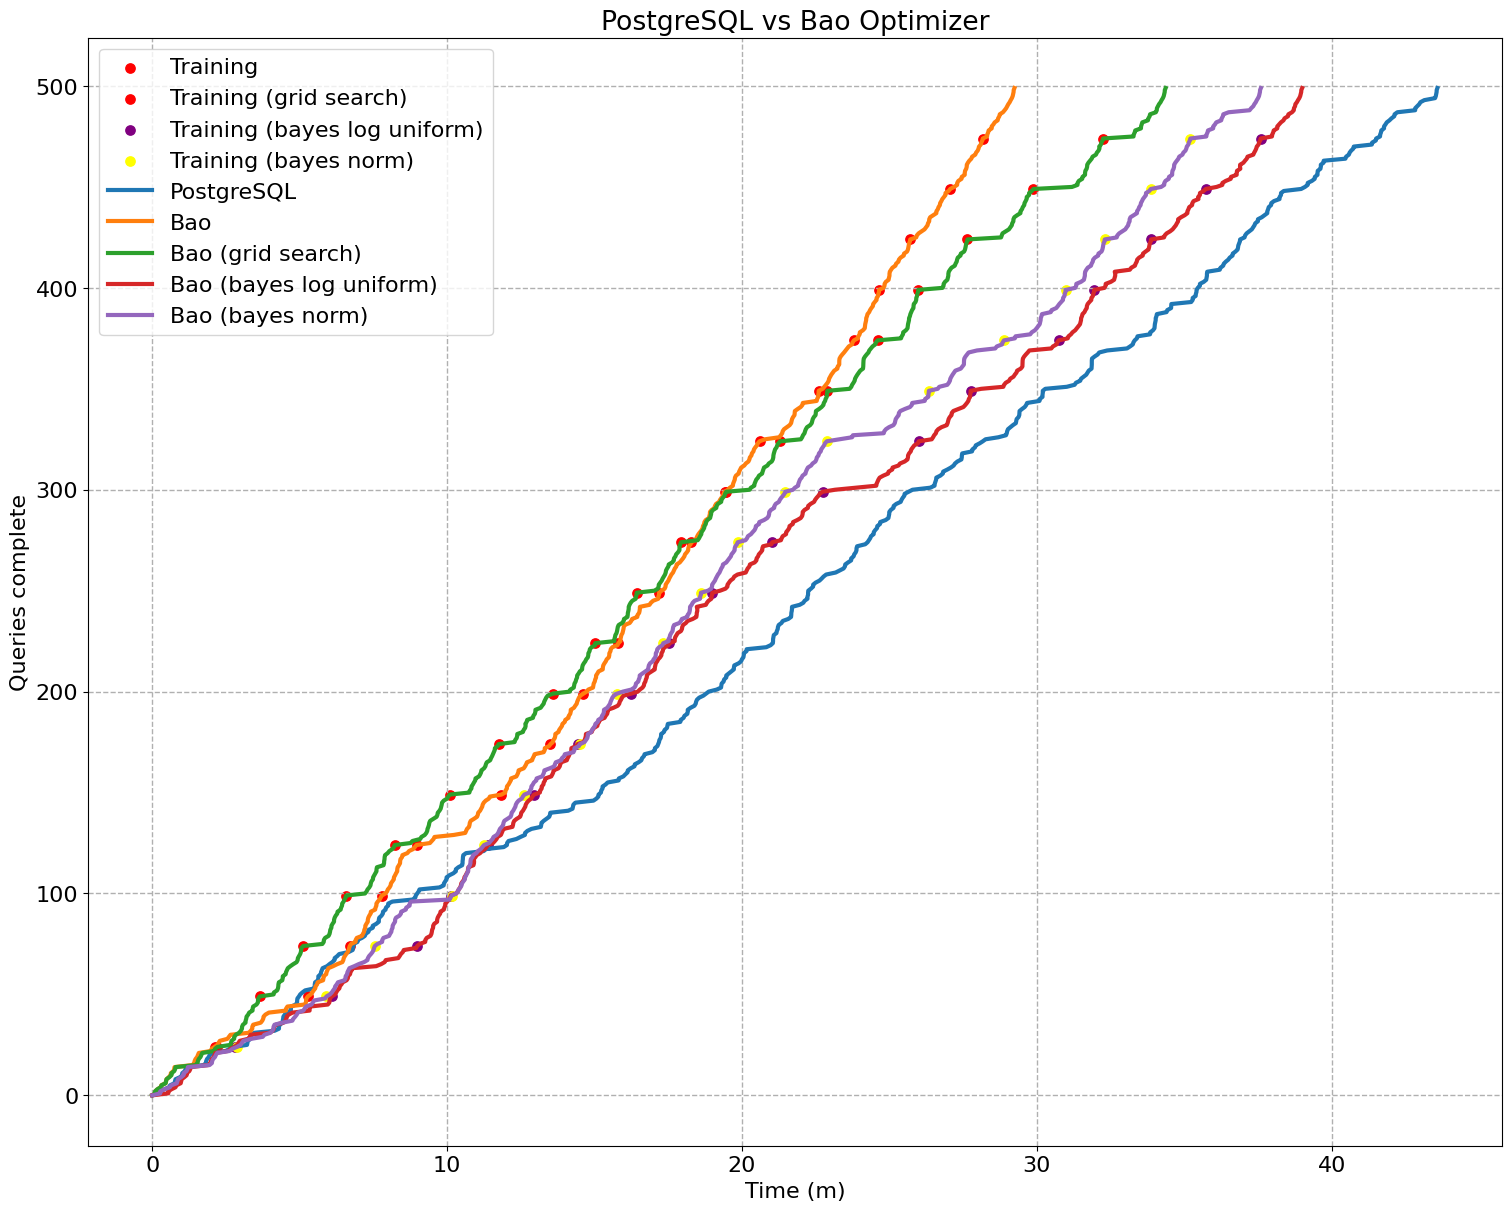

In [4]:
queries_complete = np.arange(0, len(pg_times))

fig, ax = plt.subplots(1, 1, figsize=(15, 12), constrained_layout=True)

train_y = []
for tt in training_times:
    idx = np.searchsorted(bao_times, tt)
    train_y.append(idx)
    
plt.scatter(training_times, train_y, s=45, color="red", label="Training")
plt.scatter(gs_training_times, train_y, s=45, color="red", label="Training (grid search)")
plt.scatter(bayes_training_times, train_y, s=45, color="purple", label="Training (bayes log uniform)")
plt.scatter(bayes_norm_training_times, train_y, s=45, color="yellow", label="Training (bayes norm)")

ax.plot(pg_times, queries_complete, label="PostgreSQL", lw=3)
ax.plot(bao_times, queries_complete, label="Bao", lw=3)
ax.plot(bao_gs_times, queries_complete, label="Bao (grid search)", lw=3)
ax.plot(bayes_times, queries_complete, label="Bao (bayes log uniform)", lw=3)
ax.plot(bayes_norm_times, queries_complete, label="Bao (bayes norm)", lw=3)

ax.set_xlabel("Time (m)")
ax.set_ylabel("Queries complete")
ax.set_title("PostgreSQL vs Bao Optimizer")

ax.grid(linestyle="--", linewidth=1)
ax.legend()
fig.savefig("queries_vs_time.svg")

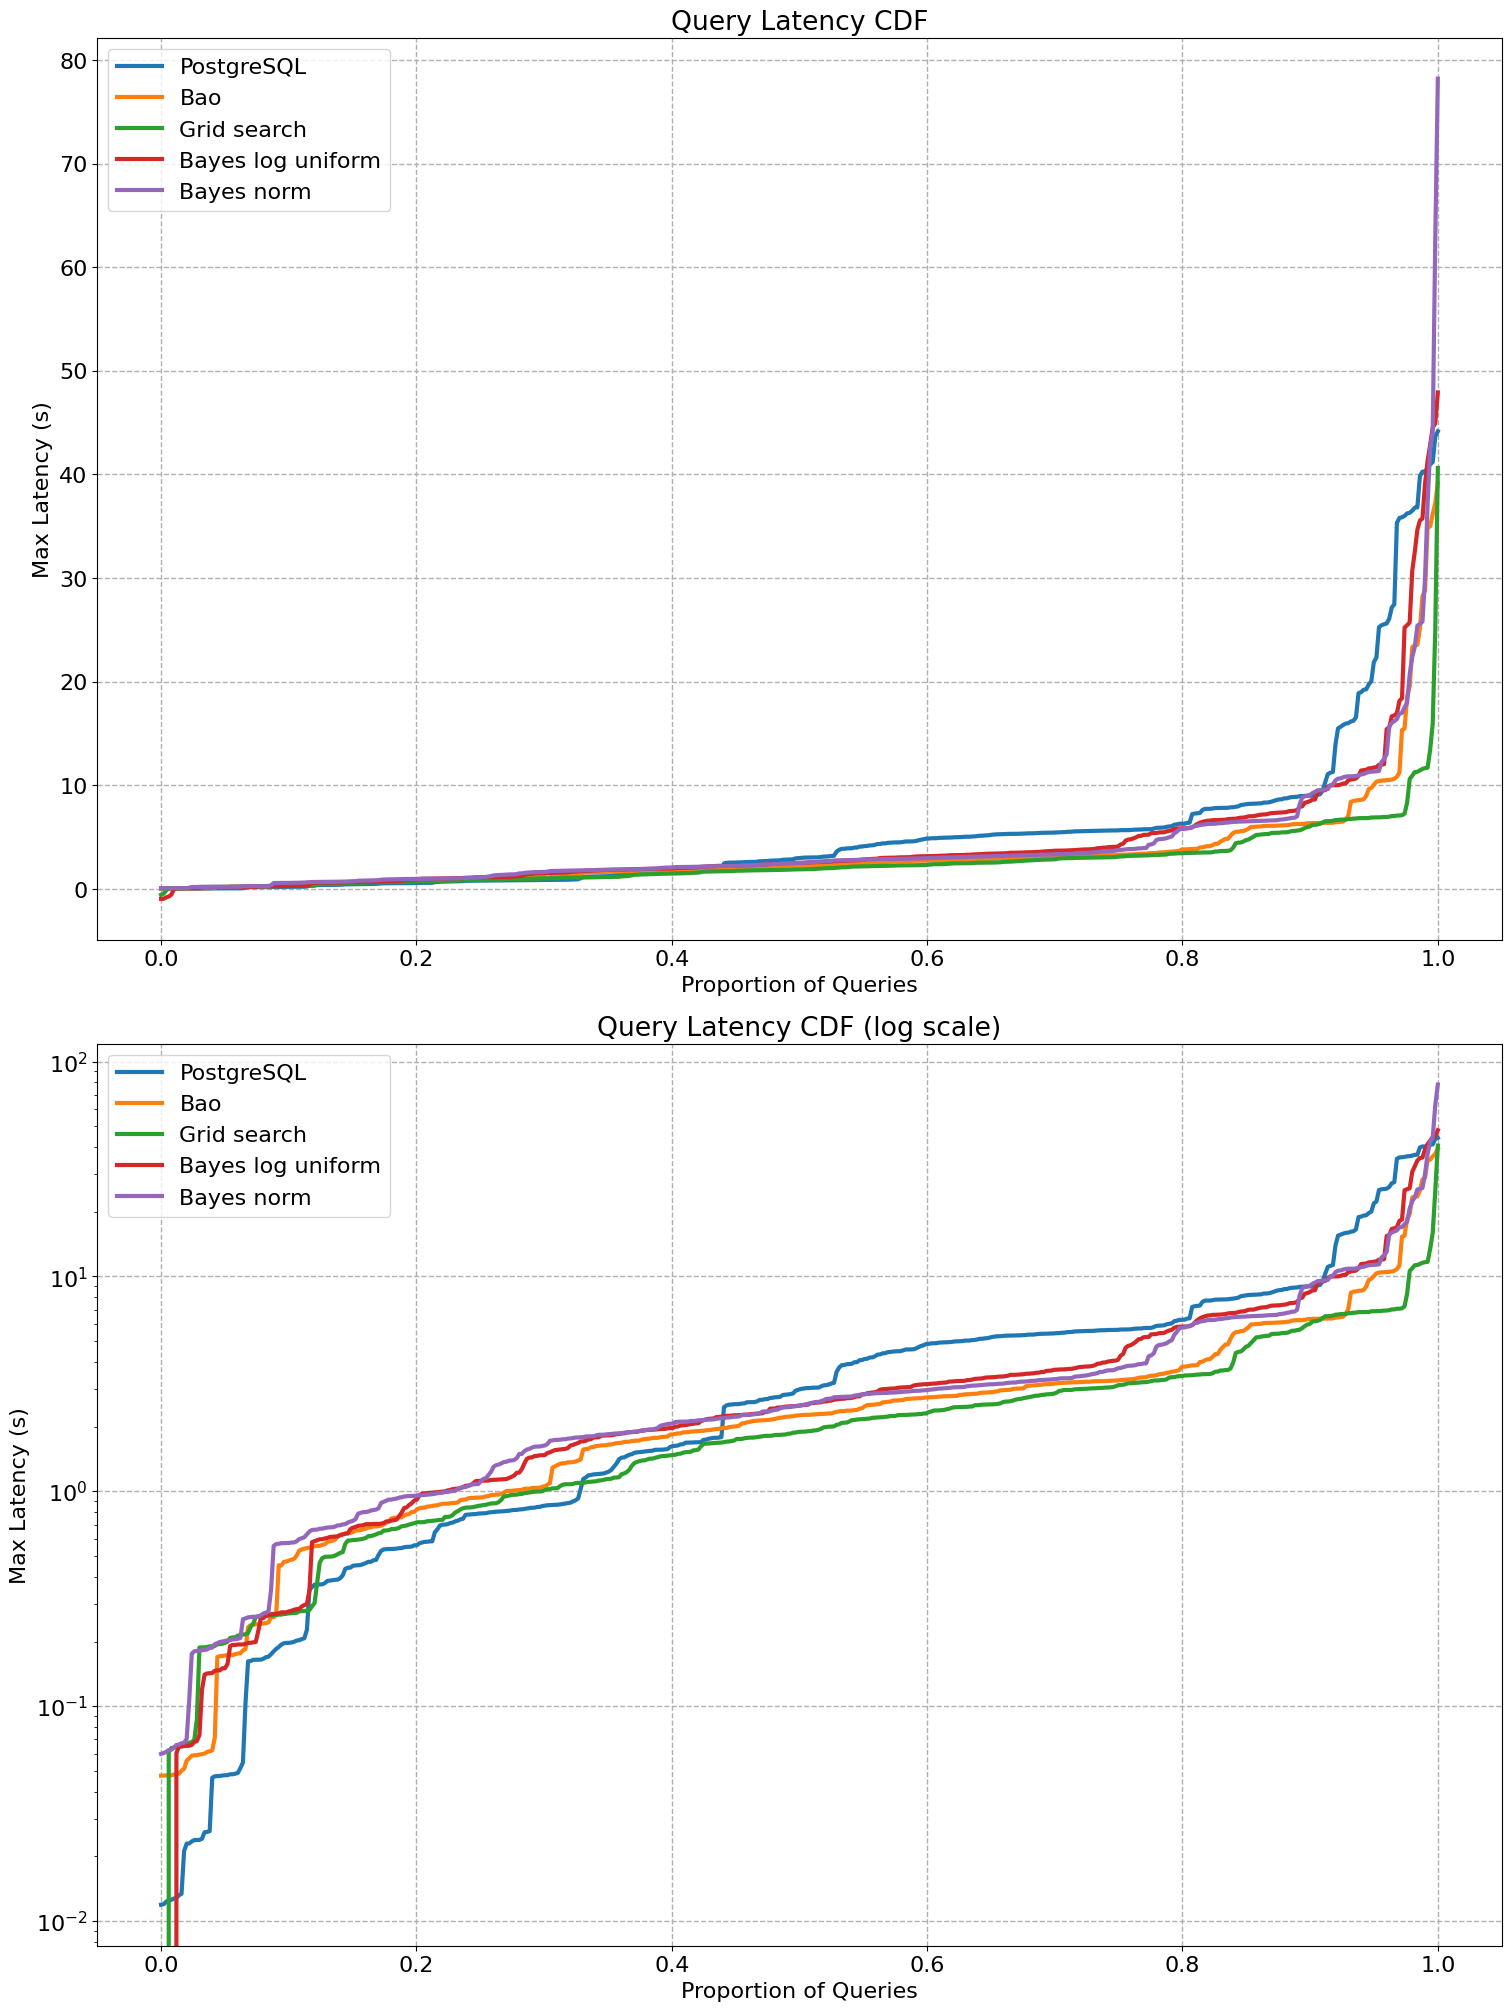

In [5]:
all_pg_times = sorted([x[4] for x in pg_data])
all_bao_times = sorted([x[4] for x in bao_data])
all_bao_gs_times = sorted([x[4] for x in bao_gs_data])
all_bayes_times = sorted([x[4] for x in bayes_data])
all_bayes_norm_times = sorted([x[4] for x in bayes_norm_data])

fig, axes = plt.subplots(2, 1, figsize=(15, 20), constrained_layout=True)

ax = axes[0]
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_pg_times, lw=3, label="PostgreSQL")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_times, lw=3, label="Bao")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_gs_times, lw=3, label="Grid search")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bayes_times, lw=3, label="Bayes log uniform")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bayes_norm_times, lw=3, label="Bayes norm")

ax.grid(linestyle="--", linewidth=1)
ax.set_xlabel("Proportion of Queries")
ax.set_ylabel("Max Latency (s)")
ax.set_title("Query Latency CDF")
ax.legend()

ax = axes[1]
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_pg_times, lw=3, label="PostgreSQL")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_times, lw=3, label="Bao")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_gs_times, lw=3, label="Grid search")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bayes_times, lw=3, label="Bayes log uniform")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bayes_norm_times, lw=3, label="Bayes norm")

ax.grid(linestyle="--", linewidth=1)
ax.set_xlabel("Proportion of Queries")
ax.set_ylabel("Max Latency (s)")
ax.set_title("Query Latency CDF (log scale)")
ax.legend()
ax.set_yscale("log")
fig.savefig("cdf.svg")

In [6]:
# get the Average PG time for each query
pg_query_time = {}
pg_query_cnt = {}
for itm in pg_data:
    if itm[3] not in pg_query_time:
        pg_query_time[itm[3]] = 0
        pg_query_cnt[itm[3]] = 0
    pg_query_time[itm[3]] += itm[4]
    pg_query_cnt[itm[3]] += 1

for name, _ in pg_query_time.items():
    pg_query_time[name] /= pg_query_cnt[name]

# Get other query times from the 100 query
bao_query_times = defaultdict(list)
for itm in bao_data[100:]:
    bao_query_times[itm[3]].append(itm[4])

bao_gs_query_times = defaultdict(list)
for itm in bao_gs_data[100:]:
    bao_gs_query_times[itm[3]].append(itm[4])

bayes_query_times = defaultdict(list)
for itm in bayes_data[100:]:
    bayes_query_times[itm[3]].append(itm[4])

bayes_norm_query_times = defaultdict(list)
for itm in bayes_norm_data[100:]:
    bayes_norm_query_times[itm[3]].append(itm[4])

max_repeats = max(len(x) for x in bao_query_times.values())

def extract_q_number(x):
    return int(x[x.find("/q")+2:x.find("_", x.find("/q"))])

q_order = sorted(bao_query_times.keys(), key=extract_q_number)

grid_bao = [bao_query_times[x] for x in q_order]
grid_bao_gs = [bao_gs_query_times[x] for x in q_order]
grid_bayes = [bayes_query_times[x] for x in q_order]
grid_bayes_norm = [bayes_norm_query_times[x] for x in q_order]

reg_data = []
for idx, q in enumerate(q_order):
    reg_data.append({"Q": f"q{extract_q_number(q)}", 
                     "PG": pg_query_time[q],
                     "Bao worst": max(grid_bao[idx]),
                     "Bao best": min(grid_bao[idx]),
                     "Grid search worst": max(grid_bao_gs[idx]),
                     "Grid search best": min(grid_bao_gs[idx]),
                     "Bayes log uniform worst": max(grid_bayes[idx]),
                     "Bayes log uniform best": min(grid_bayes[idx]),
                     "Bayes norm worst": max(grid_bayes_norm[idx]),
                     "Bayes norm best": min(grid_bayes_norm[idx]),
                    })

def color_regression(col):
    def c_for_diff(diff):
        if diff < -2:
            return "background-color: #9ee3ad"
        elif diff > 2:
            return "background-color: #f27281"
        elif diff > 0:
            return "background-color: yellow"
        else:
            return "background-color: white"
            
        
    to_r = [""]
    
    pg, bao_worst, bao_best, bao_gs_worst, bao_gs_best, bayes_worst, bayes_best, bayes_norm_worst, bayes_norm_best = col

    
    to_r.append(c_for_diff(bao_worst - pg))
    to_r.append(c_for_diff(bao_best - pg))
    to_r.append(c_for_diff(bao_gs_worst - pg))
    to_r.append(c_for_diff(bao_gs_best - pg))
    to_r.append(c_for_diff(bayes_worst - pg))
    to_r.append(c_for_diff(bayes_best - pg))
    to_r.append(c_for_diff(bayes_norm_worst - pg))
    to_r.append(c_for_diff(bayes_norm_best - pg))

    return to_r

reg_data = pd.DataFrame(reg_data).set_index("Q")
reg_data.style.apply(color_regression, axis=1).format(precision=2)

,PG,Bao worst,Bao best,Grid search worst,Grid search best,Bayes log uniform worst,Bayes log uniform best,Bayes norm worst,Bayes norm best
Q,,,,,,,,,
q1,6.06,5.81,2.25,2.57,2.41,6.83,1.56,6.27,2.15
q2,38.62,4.01,3.23,3.54,1.96,44.90,2.99,42.53,3.17
q3,1.60,3.25,2.77,3.51,1.50,3.68,2.02,62.80,1.83
q4,1.04,2.28,0.88,1.16,1.03,2.26,1.01,2.15,0.95
q5,8.57,1.99,1.77,2.39,0.63,10.47,1.93,2.03,1.80
q6,8.20,2.71,2.52,13.41,2.69,10.56,2.68,12.53,2.49
q7,17.42,19.51,3.11,15.93,1.35,18.39,1.66,17.96,1.60
q8,6.31,2.49,2.13,2.38,2.17,6.92,0.70,6.22,2.13
q9,5.71,2.82,2.72,3.12,1.42,5.85,2.97,5.52,2.79


In [7]:
reg_data.head(12).style.apply(color_regression, axis=1).format(precision=2)

,PG,Bao worst,Bao best,Grid search worst,Grid search best,Bayes log uniform worst,Bayes log uniform best,Bayes norm worst,Bayes norm best
Q,,,,,,,,,
q1,6.06,5.81,2.25,2.57,2.41,6.83,1.56,6.27,2.15
q2,38.62,4.01,3.23,3.54,1.96,44.90,2.99,42.53,3.17
q3,1.60,3.25,2.77,3.51,1.50,3.68,2.02,62.80,1.83
q4,1.04,2.28,0.88,1.16,1.03,2.26,1.01,2.15,0.95
q5,8.57,1.99,1.77,2.39,0.63,10.47,1.93,2.03,1.80
q6,8.20,2.71,2.52,13.41,2.69,10.56,2.68,12.53,2.49
q7,17.42,19.51,3.11,15.93,1.35,18.39,1.66,17.96,1.60
q8,6.31,2.49,2.13,2.38,2.17,6.92,0.70,6.22,2.13
q9,5.71,2.82,2.72,3.12,1.42,5.85,2.97,5.52,2.79
